### Learning, Information and Knowledge Systems Lab, SEAS, Harvard University
### Hsiang Hsu
#### hsianghsu@g.harvard.edu

# Bottleneck Problem

**Fall 2017**<br/>
**Instructors**: Professor Flavio Calmon

---

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import ConvexHull
from scipy.optimize import fsolve, linprog
from numpy.linalg import norm, inv, matrix_power
from scipy.integrate import simps
from scipy.linalg import sqrtm, svd
from sympy import Matrix

## [WW'75] IV Evaluation of F
### A. Binary Symmetric Channel

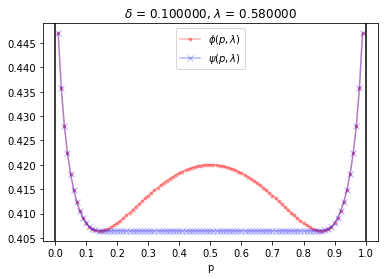

In [2]:
p_list = np.linspace(0.01, 0.99, 99)
error_prob = 0.1
l = 0.58
def hb(p):
    return -p*np.log2(p) -(1-p)*np.log2(1-p) 
def phi(p, lambda_, delta):
    return hb(delta+(1-2*delta)*p) - lambda_*hb(p)
def psi(p, lambda_, delta):
    result = []
    p_lambda = p_list[np.argmin(phi(p, lambda_, delta))]
    for i in range(len(p)):
        if p[i] >= p_lambda and p[i] <= 1 - p_lambda:
            result.append(np.min(phi(p, lambda_, delta)))
        else:
            result.append(phi(p[i], lambda_, delta))
    return result

def F_T(q, x, delta):
    temp = []
    lambda_ = np.linspace(0, 1, 101)
    for l in lambda_:
        temp.append(psi(q, l, delta) + l*x)
    return np.max(temp)

plt.plot(figsize=(10, 5))
plt.plot(p_list, phi(p_list, l, error_prob), 'r.-', alpha = 0.3, label='$\phi(p, \lambda)$');
plt.plot(p_list, psi(p_list, l, error_prob), 'bx-', alpha = 0.3, label='$\psi(p, \lambda)$');
plt.axvline(x = 0.0, color='k')
plt.axvline(x = 1.0, color='k')
plt.xticks(np.linspace(0, 1, 11));
plt.xlabel('p')
plt.legend(loc='best')
plt.title('$\delta$ = %f, $\lambda$ = %f'%(error_prob, l))


### B. Symmetric Binary Erasure Channel

## Mrs. and Mr. Gerber's Lemma

In [32]:
''' Helper Functions '''
# Binary Entropy Function
def hb(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p*np.log2(p)-(1-p)*np.log2(1-p)

# Binary Entropy Inverted Function
def hbv(h):
    f = lambda x: x**x * (1-x)**(1-x) - 2**(-h)
    return fsolve(f, 0)

# Complement Multiplication Operator
def star(a, b):
    return (1-a)*b+(1-b)*a


def MSGL_L(x, delta):
    return hb(star(delta, hbv(x)))
def MSGL_U(x, delta, q):
    f = lambda a: x- a*hb(q/max(a, 2*q))
    a = fsolve(f, 0.5)
    return a*hb(star(q/max(a, 2*q), delta)) + (1-a)*hb(delta)
    

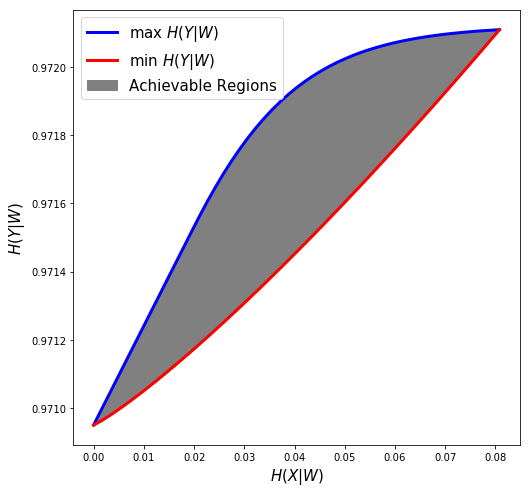

In [4]:
# crossover probability
delta = 0.4
#
q = 0.01

x = np.linspace(0, hb(q), 51)
MSGL_upper = []
MSGL_lower = []
for i in range(len(x)):
    MSGL_upper.append(MSGL_U(x[i], delta, q)[0])
    MSGL_lower.append(MSGL_L(x[i], delta)[0])
plt.figure(figsize=(8, 8))
plt.plot(x, MSGL_upper, 'b-', label='$\max\ H(Y|W)$', linewidth=3)
plt.plot(x, MSGL_lower, 'r-', label='$\min\ H(Y|W)$', linewidth=3)
plt.fill_between(x, MSGL_lower, MSGL_upper, color='gray', label='Achievable Regions')
plt.xlabel('$H(X|W)$', fontsize = 15)
plt.ylabel('$H(Y|W)$', fontsize = 15)
plt.legend(loc='best', fontsize=15)

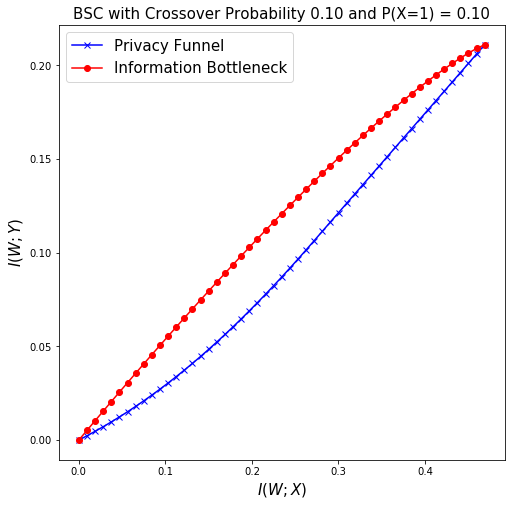

In [41]:
# crossover probability
delta = 0.1
# 
q = 0.1

x = np.linspace(0, hb(q), 51)
I_WX = []
I_WY_min = []
I_WY_max = []
for i in range(len(x)):
    I_WX.append(hb(q) - x[i])
    I_WY_min.append(hb(star(q, delta)) - MSGL_U(x[i], delta, q))
    I_WY_max.append(hb(star(q, delta)) - MSGL_L(x[i], delta))
 
plt.figure(figsize=(8, 8))
plt.plot(I_WX, I_WY_min, 'bx-', label='Privacy Funnel')
plt.plot(I_WX, I_WY_max, 'ro-', label='Information Bottleneck')
plt.xlabel('$I(W; X)$', fontsize = 15)
plt.ylabel('$I(W; Y)$', fontsize = 15)
plt.legend(loc='best', fontsize=15)
plt.title('BSC with Crossover Probability %.2f and P(X=1) = %.2f'%(delta, q), fontsize=15)

## IB and PF in $\chi^2$ divergence

In [43]:
''' Helper Functions '''
def stochastic_matrix(n, m):
    matrix = np.random.rand(n,m)
    return matrix/np.sum(matrix)

def stochastic_channel(n, m):
    matrix = np.random.rand(n,m)
    return matrix/np.sum(matrix, axis=0)

def stochastic_vector(n, s):
    matrix = np.random.rand(n,s)
    return matrix/np.sum(matrix, axis=0)

def marginalize(P, axis):
    if axis == 'x':
        return np.sum(P, 1)
    elif axis == 'y':
        return np.sum(P, 0)
    else:
        print('Error #1')
        return
    
def Df(f, p, q):
    result = 0
#     print(min(p.shape[0], q.shape[0]))
    for i in range(min(p.shape[0], q.shape[0])):
#         print(i)
#         print(p[i])
#         print(q[i])
        result = result + q[i]*f(p[i]/q[i])
    return result

def phi_T(f, g, lambda_, p, p_x, p_y, T):
#     print(np.dot(T, p))
#     print(P_Y)
#     print(Df(g, np.dot(T, p)[0], p_y))
    result = Df(g, np.dot(T, p).transpose(), p_y) - lambda_*Df(f, p, p_x)
    return result

def BSC_matrix(delta):
    return np.matrix([[1-delta, delta], [delta, 1-delta]])

def BSC_general(a, b):
    return np.matrix([[1-a, 1-b], [a, b]])

def H(p):
    result = 0
    for i in range(len(p)):
        result = result - p[i]*np.log2(p[i])
    return result[0]

# def convex_envelope(p, vertex):
    
#     return 
# def algo(hull, number_of_samples, )

# def Lee_T(lambda_, f, g, p_xw, p_x, p_yw, p_y):
#     return 

''' f-divergence '''
# KL Divergence
kl = lambda t: t*np.log2(t)
# Chi-squared Divergence
ci = lambda t: t**2 - 1

In [44]:
m, n = 2, 2
b = 1
P_XY = stochastic_matrix(m, n)
P_X = marginalize(P_XY, 'x').reshape((P_XY.shape[0], 1))
# P_Y = marginalize(P_XY, 'y').reshape((P_XY.shape[1], 1))
# T = BSC_matrix(0.1)
T = BSC_general(0.9, 0.1)
# T = stochastic_channel(n, m)
P_Y = np.dot(T, P_X)

In [45]:
number_of_samples = 100
lambda_ = 0.5
x = 1
p = stochastic_vector(m, number_of_samples)
Phi = np.zeros((1, number_of_samples))
for i in range(number_of_samples):
    Phi[0][i] = phi_T(kl, kl, lambda_, p[:, i], P_X, P_Y, T)

geometry = np.vstack((p[1:, :], Phi))
points = np.transpose(geometry)


# print(points.shape)

hull = ConvexHull(points)

vertex_index = hull.vertices
vertex = points[vertex_index]

# print(number_of_samples-len(vertex_index))

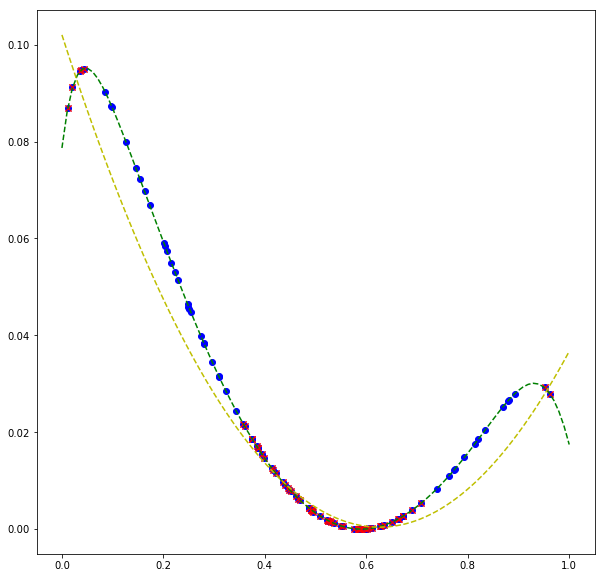

In [68]:
fig = plt.figure(figsize=(10, 10))
x = points[:, 0]
y = points[:, 1]

plt.plot(x, y, 'bo')
for v in hull.simplices:
    plt.plot(x[v], y[v], 'rx')

vertex_index = hull.vertices
# print(len(vertex_index))

z = np.polyfit(x, y, 11)
poly = np.poly1d(z)
xp = np.linspace(0, 1, 100)
plt.plot(xp, poly(xp), 'g--')

z = np.polyfit(points[vertex_index, 0], points[vertex_index, 1], 2)
poly = np.poly1d(z)
xp = np.linspace(0, 1, 100)
plt.plot(xp, poly(xp), 'y--')

In [54]:
print(poly(P_X[0]))

[ 0.01300419]


## Generalized Mrs. and Mr. Gerber's Lemma

In [106]:
''' Helper Functions '''
# Binary Entropy Function
def hb(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p*np.log2(p)-(1-p)*np.log2(1-p)

# Binary Entropy Inverted Function
def hbv(h):
    f = lambda x: x**x * (1-x)**(1-x) - 2**(-h)
    return fsolve(f, 0)

# Complement Multiplication Operator
def star(a, b):
    return (1-a)*b+(1-b)*a

# Mr./Mrs. Gerber's Lemma
def MSGL_L(x, delta):
    return hb(star(delta, hbv(x)))
def MSGL_U(x, delta, q):
    f = lambda a: x- a*hb(q/max(a, 2*q))
    a = fsolve(f, 0.5)
    return a*hb(star(q/max(a, 2*q), delta)) + (1-a)*hb(delta)

# Renyi Entropy
def Hb(b, P_X):
    sum_ = 0
    for i in range(len(P_X)):
        sum_ = sum_ + P_X[i]**b
    return 1/(1-b)*np.log(sum_)
def Kb(b, P_X):
    return np.exp((1-b)/b*Hb(b, P_X))

# Generalized Mr./Mrs. Gerber's Lemma
def GMRGL(x, q, delta, b):
    f = lambda a: Kb(b, [a, 1-a])-x
    p = fsolve(f, 0.5)
    return Kb(b, [star(p, delta), star(1-p, delta)])
def GMSGL(x, q, delta, b):
    f = lambda a: (1-a) + a*Kb(b, [q/max(a, 2*q), 1-q/max(a, 2*q)]) - x
    a = fsolve(f, 0.5)
    return a*Kb(b, [star(q/max(a, 2*q), delta), 1-star(q/max(a, 2*q), delta)]) + (1-a)*Kb(b, [delta, 1-delta])

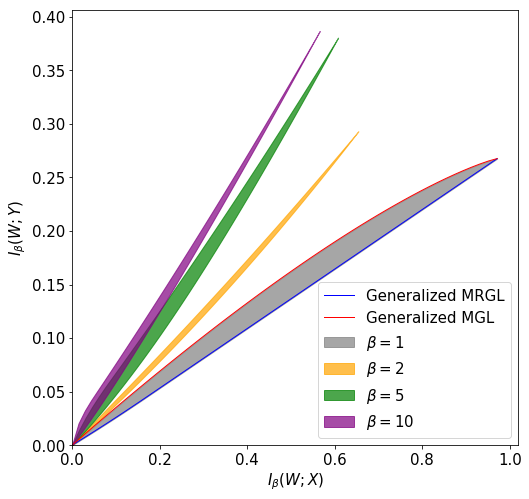

In [108]:
''' Setting Up '''
# Pr(X=1) = q
q = 0.4
# Crossover Probability \delta
delta = 0.2
# Order
B = [2, 5, 10]
# Resolution of the Image
n_sample = 51

P_X = [q, 1-q]
P_Y = [star(q, delta), star(1-q, delta)]
Ib_XW, Ib_YW_min, Ib_YW_max = \
     np.zeros((len(B)+1, n_sample)), np.zeros((len(B)+1, n_sample)), np.zeros((len(B)+1, n_sample))

figure_description = 'BSC_MGL.eps'

''' Mr./Mrs. Gerber's Lemma '''
H_X = np.linspace(0, hb(q), n_sample)    
for i in range(n_sample):
    x = H_X[i]
    Ib_XW[0][i] = hb(q) - x
    Ib_YW_min[0][i] = hb(star(q, delta)) - MSGL_U(x, delta, q)
    Ib_YW_max[0][i] = hb(star(q, delta)) - MSGL_L(x, delta)
    
plt.figure(figsize=(8, 8))
matplotlib.rcParams.update({'font.size': 15})
plt.plot(Ib_XW[0, :], Ib_YW_min[0, :], 'b-', linewidth=1, label='Generalized MRGL')
plt.plot(Ib_XW[0, :], Ib_YW_max[0, :], 'r-', linewidth=1, label='Generalized MGL')
plt.fill_between(Ib_XW[0, :], Ib_YW_min[0, :], Ib_YW_max[0, :], color='gray', label=r'$\beta = $%d'%1, alpha=0.7)
    
''' Generalized Mr./Mrs. Gerber's Lemma '''
C = ['orange', 'green', 'purple']
for j in range(1, len(B)+1):
    b = B[j-1]
    Hb_X = Hb(b, P_X)
    Hb_Y = Hb(b, P_Y)
    Kb_XgW = np.linspace(Kb(b, P_X), 1, n_sample)
    for i in range(n_sample):
        x = Kb_XgW[i]
        Ib_XW[j][i] = Hb_X - b/(1-b)*np.log(x)
        Ib_YW_min[j][i] = Hb_Y - b/(1-b)*np.log(GMRGL(x, q, delta, b)[0])
        Ib_YW_max[j][i] = Hb_Y - b/(1-b)*np.log(GMSGL(x, q, delta, b)[0])

#     plt.plot(Ib_XW[j, :], Ib_YW_min[j, :], 'b-', linewidth=1)
#     plt.plot(Ib_XW[j, :], Ib_YW_max[j, :], 'r-', linewidth=1)
    plt.fill_between(Ib_XW[j, :], Ib_YW_min[j, :], Ib_YW_max[j, :], color=C[j-1], label=r'$\beta = $%d'%b, alpha=0.7)

plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel(r'$I_\beta(W; X)$', fontsize = 15)
plt.ylabel(r'$I_\beta(W; Y)$', fontsize = 15)
plt.legend(loc='lower right', fontsize=15)
plt.savefig('Figures/%s'%figure_description, format='eps', dpi=1000)

(0, 0.41706695158679252)

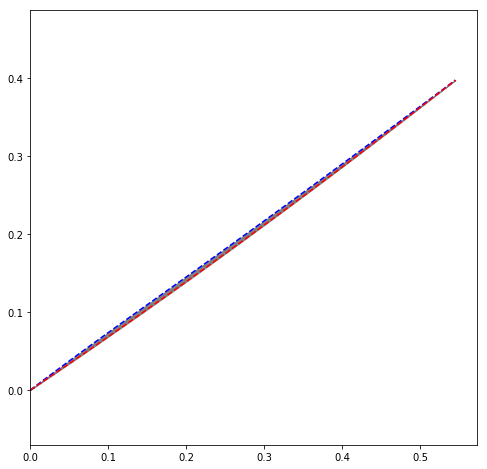

In [49]:
''' ### Test ### '''
# Arimoto Conditional Entropy
# def Hb_XgW(b, P_XgW, PW):
#     sum_ = 0
#     for i in range(len(P_w)):
#         sum_ = sum_ + PW[i]*norm(P_XgW[i, :], b)
#     return b/(1-b)*np.log(sum_)

def Hb(b, P_X):
    sum_ = 0
    for i in range(len(P_X)):
        sum_ = sum_ + P_X[i]**b
    return 1/(1-b)*np.log(sum_)

# def Kb_XgW(b, P_XgW, PW):
#     return np.exp((1-b)/b*Hb_XgW(b, P_XgW, PW))

def Kb(b, P_X):
    return np.exp((1-b)/b*Hb(b, P_X))

# def GMRGL(q, delta, n_sample):
#     ps = np.linspace(0, q, n_sample)
#     Hb_XgW, Hb_YgW = [], []
#     for i in range(n_sample):
#         p = ps[i]
#         Hb_XgW.append( b/(1-b)*np.log(Kb(b, [p, 1-p])) )
#         Hb_YgW.append( b/(1-b)*np.log(Kb(b, [star(p, delta), star(1-p, delta)])) )
#     return Hb_XgW, Hb_YgW
    
def GMRGL(x, q, delta, b):
    f = lambda a: Kb(b, [a, 1-a])-x
    p = fsolve(f, 0.5)
    return Kb(b, [star(p, delta), star(1-p, delta)])
    
def GMSGL(x, q, delta, b):
    f = lambda a: (1-a) + a*Kb(b, [q/max(a, 2*q), 1-q/max(a, 2*q)]) - x
    a = fsolve(f, 0.5)
    return a*Kb(b, [star(q/max(a, 2*q), delta), 1-star(q/max(a, 2*q), delta)]) + (1-a)*Kb(b, [delta, 1-delta])
''' Setting Up '''
# Pr(X=1) = q
q = 0.3
# Crossover Probability \delta
delta = 0.1
# Order
b = 2
#
n_sample = 51

P_X = [q, 1-q]
P_Y = [star(q, delta), star(1-q, delta)]
Hb_X = Hb(b, P_X)
Hb_Y = Hb(b, P_Y)
Kb_XgW = np.linspace(Kb(b, P_X), 1, n_sample)

Ib_XW, Ib_YW_max, Ib_YW_min = [], [], []
for i in range(n_sample):
    x = Kb_XgW[i]
    Ib_XW.append(Hb_X - b/(1-b)*np.log(x))
    Ib_YW_min.append(Hb_Y - b/(1-b)*np.log(GMRGL(x, q, delta, b)[0]))
    Ib_YW_max.append(Hb_Y - b/(1-b)*np.log(GMSGL(x, q, delta, b)[0]))
    
plt.figure(figsize=(8, 8))
plt.plot(Ib_XW, Ib_YW_max, 'b--', label='Privacy Funnel')
plt.plot(Ib_XW, Ib_YW_min, 'r--', label='Privacy Funnel')
plt.fill_between(Ib_XW, Ib_YW_min, Ib_YW_max, color='gray', label='Achievable Regions')
plt.axis('equal')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
# plt.xlabel('$I_\beta(W; X)$', fontsize = 15)
# plt.ylabel('$I_\beta(W; Y)$', fontsize = 15)
# plt.legend(loc='best', fontsize=15)
# plt.title('BSC with Crossover Probability %.2f and P(X=1) = %.2f'%(delta, q), fontsize=15)

In [18]:
P_Y

[0.34, 0.66]

## Generalized Bottleneck Problems (Geometry)
- 1. Compute $\phi(p, \lambda)$
- 2. Calculate the vertices of the convex hull
- 3. find upper and lower convex hull (***Upper and Lower is with respect to the dimension of $\phi(p, \lambda)$***)

In [15]:
''' Helper Functions '''
def stochastic_matrix(n, m):
    matrix = np.random.rand(n,m)
    return matrix/np.sum(matrix)

def stochastic_channel(n, m):
    matrix = np.random.rand(n,m)
    return matrix/np.sum(matrix, axis=0)

def stochastic_vector(n, s):
    matrix = np.random.rand(n,s)
    return matrix/np.sum(matrix, axis=0)

def marginalize(P, axis):
    if axis == 'x':
        return np.sum(P, 1)
    elif axis == 'y':
        return np.sum(P, 0)
    else:
        print('Error #1')
        return
    
def Df(f, p, q):
    result = 0
#     print(min(p.shape[0], q.shape[0]))
    for i in range(min(p.shape[0], q.shape[0])):
#         print(i)
#         print(p[i])
#         print(q[i])
        result = result + q[i]*f(p[i]/q[i])
    return result

def phi_T(f, g, lambda_, p, p_x, p_y, T):
#     print(np.dot(T, p))
#     print(P_Y)
#     print(Df(g, np.dot(T, p)[0], p_y))
    result = Df(g, np.dot(T, p).transpose(), p_y) - lambda_*Df(f, p, p_x)
    return result

def BSC_matrix(delta):
    return np.matrix([[1-delta, delta], [delta, 1-delta]])

def BSC_general(a, b):
    return np.matrix([[1-a, 1-b], [a, b]])

def H(p):
    result = 0
    for i in range(len(p)):
        result = result - p[i]*np.log2(p[i])
    return result[0]

# def convex_envelope(p, vertex):
    
#     return 
# def algo(hull, number_of_samples, )

# def Lee_T(lambda_, f, g, p_xw, p_x, p_yw, p_y):
#     return 

def convex_hull(points):
    points = sorted(set(points))
    
    if len(points) <= 1:
        return points

    def cross(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

    # Build lower hull 
    lower = []
    for p in points:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)

    # Build upper hull
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    return lower[:-1], upper[:-1]

''' f-divergence '''
# KL Divergence
kl = lambda t: t*np.log2(t)
# Chi-squared Divergence
ci = lambda t: t**2 - 1

In [16]:
m, n = 2, 2
b = 1
P_XY = stochastic_matrix(m, n)
P_X = marginalize(P_XY, 'x').reshape((P_XY.shape[0], 1))
# P_Y = marginalize(P_XY, 'y').reshape((P_XY.shape[1], 1))
# T = BSC_matrix(0.1)
T = BSC_general(0.9, 0.1)
# T = stochastic_channel(n, m)
P_Y = np.dot(T, P_X)

In [17]:
number_of_samples = 100
lambda_ = 0.5
x = 1
p = stochastic_vector(m, number_of_samples)
Phi = np.zeros((1, number_of_samples))
for i in range(number_of_samples):
    Phi[0][i] = phi_T(kl, kl, lambda_, p[:, i], P_X, P_Y, T)

geometry = np.vstack((p[1:, :], Phi))
points = np.transpose(geometry)


# print(points.shape)

hull = ConvexHull(points)

vertex_index = hull.vertices
vertex = points[vertex_index]

# print(number_of_samples-len(vertex_index))

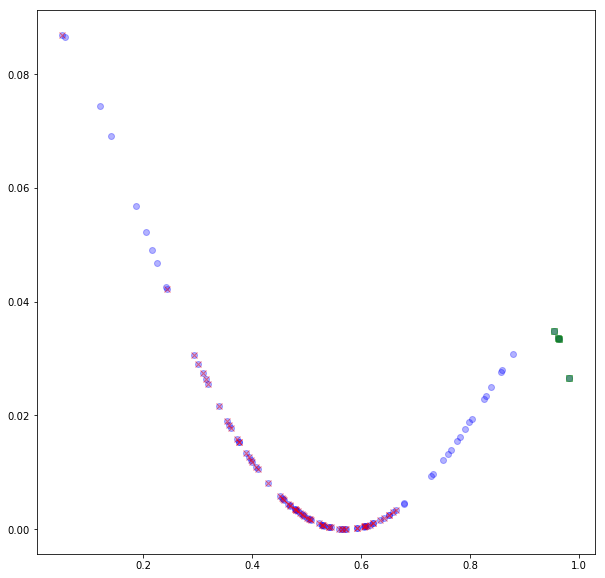

In [31]:
x = p[0].tolist()
y = Phi[0].tolist()
points_list = []
for i in range(len(x)):
    points_list.append((x[i], y[i]))
l, u = convex_hull(points_list)

fig = plt.figure(figsize=(10, 10))
# x = points[:, 0]
# y = points[:, 1]

plt.plot(x, y, 'bo', alpha=0.3)
plt.plot([l[i][0] for i in range(len(l))], [l[i][1] for i in range(len(l))], 'rx', alpha=0.5)
plt.plot([u[i][0] for i in range(len(u))], [u[i][1] for i in range(len(u))], 'gs', alpha=0.5)


In [30]:
u

[(0.9814164554997395, 0.0266131030791526),
 (0.9621243996875469, 0.03341287387673336),
 (0.9611076523007795, 0.03361038020107293),
 (0.9527469690097852, 0.034833018055858644)]

74


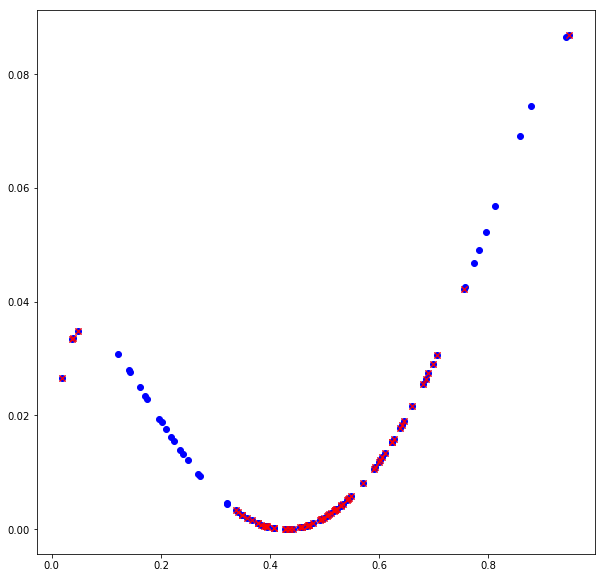

In [42]:
fig = plt.figure(figsize=(10, 10))
x = points[:, 0]
y = points[:, 1]

plt.plot(x, y, 'bo')
for v in hull.simplices:
    plt.plot(x[v], y[v], 'rx')

vertex_index = hull.vertices
print(len(vertex_index))

In [59]:
if number_of_samples-len(vertex_index) == 0:
#     f = lambda a: Df(kl, a, P_X)-x
#     p_lambda = fsolve(f, 1/m*np.ones((m, 1)))
#     print(Df(kl, P_X, P_X))
    print('Convex Hull Matches!!!')
else:
    print('Convex Hull NOT Matches!!!')

Convex Hull Matches!!!


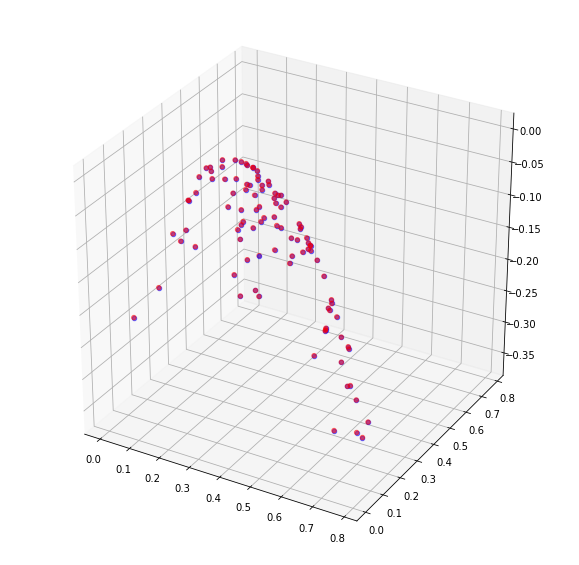

In [156]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

ax.scatter(xs=x, ys=y, zs=z, c='r', alpha=0.5)
for v in hull.vertices:
    ax.scatter(xs=points[v, 0], ys=points[v, 1], zs=points[v, 2], c='b', alpha=.5)

In [121]:
H(P_X)

1.5617587619610225

In [150]:
vertex_index.shape

(10000,)

In [69]:
T

array([[ 0.98598549,  0.64329866,  0.67389576],
       [ 0.01401451,  0.35670134,  0.32610424]])

## Estimation Bottleneck (Sampling)

In [60]:
''' Helper Functions '''
def stochastic_matrix(n, m):
    matrix = np.random.rand(n,m)
    return matrix/np.sum(matrix)
def marginalize(P, axis):
    if axis == 'x':
        return np.sum(P, 1)
    elif axis == 'y':
        return np.sum(P, 0)
    else:
        print('Error #1')
        return

def PIC(P_XY, P_X, P_Y):
    D_X, D_Y = np.diag(P_X), np.diag(P_Y)
    D_X_sqrtinv, D_Y_sqrtinv = sqrtm(inv(D_X)), sqrtm(inv(D_Y))
    Q = np.matmul(np.matmul(D_X_sqrtinv, P_XY), D_Y_sqrtinv)
    U, S, V = svd(Q)
    f, g = np.matmul(D_X_sqrtinv, U), np.matmul(D_Y_sqrtinv, V)
    pic = np.sqrt(S)
    return pic, f, g

def sampling_A(D_X_sqrtinv, f):
    size = len(D_X_sqrtinv)
    J = np.ones((size, size))
    left = -J
    right = np.matmul(D_X_sqrtinv - np.identity(size), J)
#     A = stochastic_matrix(size, size)
#     print(np.matmul(f, A))
#     print(left)
#     print(right)
    C = np.random.uniform(left, right, left.shape)
    A = np.matmul(inv(f), C)
#     print(C)
#     while np.greater(np.matmul(f, A), right).any() or np.greater(left, np.matmul(f, A)).any():
#         A = stochastic_matrix(size, size)
    return A


def EB_LP(PF1, A, pic_matrix, beta):
    core = matrix_power(pic_matrix, 2) - beta*np.identity(len(pic_matrix))
    core = np.matmul(np.matmul(A.transpose(), core), A)
#     print(core.shape)
#     print(core)
    Tau = (-1*core.diagonal()).tolist()
#     print(Tau)
    C = A
    a_eq = np.vstack((np.ones(len(C)), C)).tolist()
#     print(a_eq)
#     print(len(a_eq))
    b = np.zeros(len(C)+1).tolist()
    b[0] = 1
#     print(b)
#     print(len(b))
    result = linprog(c=Tau, A_eq=a_eq, b_eq=b, bounds=(0, None), method='simplex', \
                     options={'tol':1e-5})
    return result, Tau, a_eq, b


In [63]:
# Construct P_XY
m, n, k = 10, 20, 5
b = 1
P_XY = stochastic_matrix(m, n)
P_X = marginalize(P_XY, 'x')
P_Y = marginalize(P_XY, 'y')
D_X, D_Y = np.diag(P_X), np.diag(P_Y)
D_X_sqrtinv, D_Y_sqrtinv = sqrtm(inv(D_X)), sqrtm(inv(D_Y))

pic, PF1, PF2 = PIC(P_XY, P_X, P_Y)
pic_matrix = np.diag(pic)


In [64]:
A = sampling_A(D_X_sqrtinv, PF1)
res, C, a_eq, b_eq = EB_LP(PF1, A, pic_matrix, b)
print(res.fun)
print(res.x)
print(res.status)
print(res.success)
print(res.message)
print(res.nit)

0.869094847559
nan
2
False
Optimization failed. Unable to find a feasible starting point.
14


In [219]:
C, a_eq, b

([0.027069302479776694, 0.0019763604187892393, 0.04201722220598258],
 [[1.0, 1.0, 1.0],
  [-0.03267725358883826, 0.07106428237799942, -0.1708592577324899],
  [0.3572264148852309, 0.15596446454012358, 0.334402105259359],
  [0.07575057886462608, 0.05858157598346534, 0.30813320713454245]],
 [1, 0.0, 0.0, 0.0])

In [134]:
# c = [-1, 4, 5]
# A = [[-3, 1, 5], [1, 2, 3]]
# b = [6, 4]
res = linprog(C, A_eq=a_eq, b_eq=b, options={"disp": True})
print(res.x)

Optimization failed. Unable to find a feasible starting point.
nan


In [3]:
a = [[-3, 1, 5], [1, 2, 3]]
b = [[-4, 1, 5], [1, 2, 3]]
np.greater(a, b).any()

True

## Estimation Bottleneck

In [5]:
''' Some Helper Functions '''
def stochastic_matrix(n, m):
    matrix = np.random.rand(n,m)
    return matrix/np.sum(matrix)
def marginalize(P, axis):
    if axis == 'x':
        return np.sum(P, 1)
    elif axis == 'y':
        return np.sum(P, 0)
    else:
        print('Error #1')
        return

def PIC(P_XY, P_X, P_Y):
    D_X, D_Y = np.diag(P_X), np.diag(P_Y)
    D_X_sqrtinv, D_Y_sqrtinv = sqrtm(inv(D_X)), sqrtm(inv(D_Y))
    Q = np.matmul(np.matmul(D_X_sqrtinv, P_XY), D_Y_sqrtinv)
    U, S, V = svd(Q)
    f, g = np.matmul(D_X_sqrtinv, U), np.matmul(D_Y_sqrtinv, V)
    pic = np.sqrt(S)
    return pic, f, g

def sampling_A(D_X_sqrtinv, f):
    size = len(D_X_sqrtinv)
    J = np.ones((size, size))
    left = -J
    right = np.matmul(D_X_sqrtinv - np.identity(size), J)
    A = stochastic_matrix(size, size)
    while np.greater(np.matmul(f, A), right).any() or np.greater(left, np.matmul(f, A)).any():
        A = stochastic_matrix(size, size)
    return A

# def null(A, eps=1e-15):
#     u, s, vh = svd(A)
#     null_mask = (s <= eps)
#     null_space = scipy.compress(null_mask, vh, axis=0)
#     return scipy.transpose(null_space)

def nullspace(A, atol=1e-13, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns


# def sampling_w(f, A, eps=1e-5):
#     FA = Matrix(np.matmul(f, A))
#     size = f.shape[0]
#     w = stochastic_matrix(size, 1)
#     FAw = np.multiply(FA, w)
#     while np.greater(FAw, eps*np.ones(FAw.shape)).any() or np.greater(-eps*np.ones(FAw.shape), FAw).any():
#         w = stochastic_matrix(size, 1)
#         FAw = np.multiply(FA, w)
#     return w

def sampling_w(f, A, eps=1e-5):
    FA = np.matmul(f, A)
    ww = nullspace(FA, atol=1e-2, rtol=1e-2)
    w = np.zeros(len(ww))
    print(ww)
    print(type(ww))
    print(len(ww))
    if len(ww) == 0:
        print('ww is null')
        return []
    for i in range(len(ww)):
        w[i] = ww[i][0]
    return w/w.sum()

def EB(D_w_sqrt, A, pic_matrix, beta):
    temp1 = matrix_power(pic_matrix, 2) - beta*np.identity(len(pic_matrix))
    temp2 = np.matmul(D_w_sqrt, A.transpose())
    temp3 = np.matmul(A, D_w_sqrt)
    return np.trace(np.matmul(np.matmul(temp2, temp1), temp3)).real

In [6]:
# Construct P_XY
m, n, k = 10, 20, 5
P_XY = stochastic_matrix(m, n)
P_X = marginalize(P_XY, 'x')
P_Y = marginalize(P_XY, 'y')
D_X, D_Y = np.diag(P_X), np.diag(P_Y)
D_X_sqrtinv, D_Y_sqrtinv = sqrtm(inv(D_X)), sqrtm(inv(D_Y))

pic, PF1, PF2 = PIC(P_XY, P_X, P_Y)
pic_matrix = np.diag(pic)

[[ 0.25205612]
 [-0.02461435]
 [ 0.13434156]
 [ 0.00875393]
 [ 0.17083009]
 [ 0.16747355]
 [-0.12092731]
 [ 0.20215082]
 [-0.4914635 ]
 [-0.75065472]]
<class 'numpy.ndarray'>
10


(0, 0.0085346005957002233)

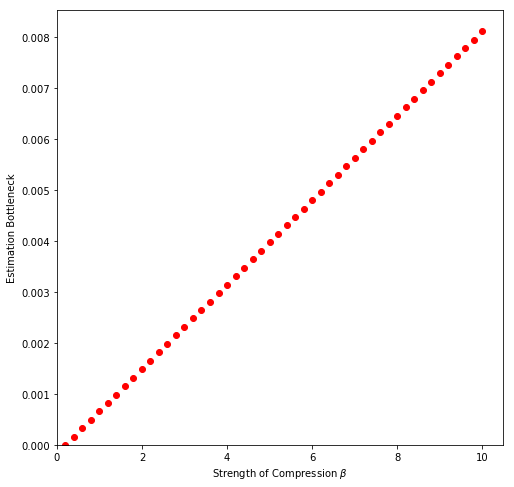

In [9]:
A = sampling_A(D_X_sqrtinv, PF1)
w = sampling_w(PF1, A)

D_w_sqrt = sqrtm(np.diag(w))


betas = np.linspace(0, 10, 51)
EBs = [];
for i in range(len(betas)):
    beta = betas[i]
    EBs.append(EB(D_w_sqrt, A, pic_matrix, beta))

plt.figure(figsize=(8, 8))
plt.plot(betas, EBs, 'ro')
plt.xlabel(r'Strength of Compression $\beta$')
plt.ylabel('Estimation Bottleneck')
plt.xlim(xmin=0)
plt.ylim(ymin=0)

In [249]:
# Construct P_XY
m, n, k = 10, 20, 5
P_XY = stochastic_matrix(m, n)
P_X = marginalize(P_XY, 'x')
P_Y = marginalize(P_XY, 'y')
D_X, D_Y = np.diag(P_X), np.diag(P_Y)
D_X_sqrtinv, D_Y_sqrtinv = sqrtm(inv(D_X)), sqrtm(inv(D_Y))
MC_number = 1000

pic, PF1, PF2 = PIC(P_XY, P_X, P_Y)
pic_matrix = np.diag(pic)


betas = np.linspace(0, 10, 51)
EBs = np.zeros((MC_number, len(betas)))
for i in range(len(betas)):
    beta = betas[i]
    for j in range(MC_number):
        A = sampling_A(D_X_sqrtinv, PF1)
        w = sampling_w(PF1, A)
        if w != []:
            D_w_sqrt = sqrtm(np.diag(w))
            EBs[j][i] = EB(D_w_sqrt, A, pic_matrix, beta)
        
EB_opt = np.max(EBs, 1)

plt.figure(figsize=(8, 8))
plt.semilogy(betas, EBs_opt, 'ro')

[[-0.17164752]
 [ 0.23573569]
 [-0.25744373]
 [-0.00955054]
 [ 0.40681381]
 [ 0.30447345]
 [ 0.17129942]
 [ 0.28833949]
 [-0.43319126]
 [-0.53875592]]
<class 'numpy.ndarray'>
10
[[ 0.1551409 ]
 [-0.20256543]
 [-0.06384229]
 [ 0.21852847]
 [ 0.55410084]
 [-0.22053899]
 [-0.2111904 ]
 [-0.21575553]
 [ 0.31308306]
 [-0.58157544]]
<class 'numpy.ndarray'>
10
[[ 0.31284926]
 [ 0.0311892 ]
 [-0.49252106]
 [ 0.08397837]
 [ 0.03277762]
 [ 0.23146983]
 [ 0.39784451]
 [-0.60090277]
 [-0.17154761]
 [ 0.21926602]]
<class 'numpy.ndarray'>
10
[[-0.35715314]
 [ 0.28651237]
 [ 0.5211439 ]
 [ 0.1252719 ]
 [ 0.39941232]
 [-0.39226145]
 [ 0.02994544]
 [-0.3432682 ]
 [-0.25254058]
 [-0.08463157]]
<class 'numpy.ndarray'>
10
[]
<class 'numpy.ndarray'>
10


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


IndexError: index 0 is out of bounds for axis 0 with size 0

In [221]:
print(j)

8


In [193]:
a = [[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]]
np.max(a, 1)

array([3, 6, 9])

In [217]:
a = np.random.multivariate_normal([0, 1], [[1, 2], [2, 1]], 10)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [218]:
a.shape

(10, 2)

## Generalized Bottleneck Problems

In [37]:
''' Helper Functions '''
def Df(f, p, q):
    result = 0
    for i in range(len(p)):
        result = result + q[i]*f(p[i]/q[i])
    return result

def phi_T(f, g, lambda_, p_xw, p_x, p_yw, p_y):
    result = Df(f, p_xw, p_x)[0] - lambda_*Df(g, p_yw, p_y)[0]
    return result

def Lee_T(lambda_, f, g, p_xw, p_x, p_yw, p_y):
    return 

''' f-divergence '''
kl = lambda t: t*np.log2(t)
ci = lambda t: t**2 - 1

In [38]:
slopes = np.linspace(0, 100, 101)


83.3333333333
83.3333333333
[[  0.           1.         -25.        ]
 [ -0.99388373  -0.11043153  -2.20863052]
 [ -0.98994949  -0.14142136  -1.69705627]
 [ -0.98058068  -0.19611614  -1.17669681]
 [  0.98058068  -0.19611614  -1.17669681]
 [  0.70710678  -0.70710678  -0.        ]
 [  0.9486833   -0.31622777  -0.63245553]
 [ -0.70710678  -0.70710678  -0.        ]
 [ -0.9486833   -0.31622777  -0.63245553]
 [  0.99388373  -0.11043153  -2.20863052]
 [  0.98994949  -0.14142136  -1.69705627]]
[]
61.6039273722743


(11, 2)

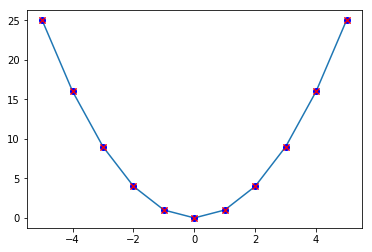

In [100]:
x = np.linspace(-5, 5, 11)
y = x**2
plt.plot(x, y)
#print(simps(y, x))

points = np.transpose(np.vstack((x, y)))
hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'bo')
for v in hull.simplices:
    plt.plot(points[v, 0], points[v, 1], 'rx')
print(simps(points[hull.vertices, 1][np.argsort(points[hull.vertices, 0])], np.sort(points[hull.vertices, 0])))
print(simps(y, x))
print(hull.equations)
print(hull.coplanar)
print(hull.area)
points.shape

In [2]:
def convex_hull(points):
    """Computes the convex hull of a set of 2D points.

    Input: an iterable sequence of (x, y) pairs representing the points.
    Output: a list of vertices of the convex hull in counter-clockwise order,
      starting from the vertex with the lexicographically smallest coordinates.
    Implements Andrew's monotone chain algorithm. O(n log n) complexity.
    """

    # Sort the points lexicographically (tuples are compared lexicographically).
    # Remove duplicates to detect the case we have just one unique point.
    points = sorted(set(points))

    # Boring case: no points or a single point, possibly repeated multiple times.
    if len(points) <= 1:
        return points

    # 2D cross product of OA and OB vectors, i.e. z-component of their 3D cross product.
    # Returns a positive value, if OAB makes a counter-clockwise turn,
    # negative for clockwise turn, and zero if the points are collinear.
    def cross(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

    # Build lower hull 
    lower = []
    for p in points:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)

    # Build upper hull
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    # Concatenation of the lower and upper hulls gives the convex hull.
    # Last point of each list is omitted because it is repeated at the beginning of the other list. 
    return lower[:-1], upper[:-1]

# Example: convex hull of a 10-by-10 grid.
#assert convex_hull([(i//10, i%10) for i in range(100)]) == [(0, 0), (9, 0), (9, 9), (0, 9)]

In [3]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

def plot_in_hull(p, hull):
    """
    plot relative to `in_hull` for 2d data
    """
    import matplotlib.pyplot as plt
    from matplotlib.collections import PolyCollection, LineCollection

    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    # plot triangulation
    poly = PolyCollection(hull.points[hull.vertices], facecolors='w', edgecolors='b')
    plt.clf()
    plt.title('in hull')
    plt.gca().add_collection(poly)
    plt.plot(hull.points[:,0], hull.points[:,1], 'o', hold=1)


    # plot the convex hull
    edges = set()
    edge_points = []

    def add_edge(i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(hull.points[ [i, j] ])

    for ia, ib in hull.convex_hull:
        add_edge(ia, ib)

    lines = LineCollection(edge_points, color='g')
    plt.gca().add_collection(lines)
    plt.show()    

    # plot tested points `p` - black are inside hull, red outside
    inside = in_hull(p,hull)
    plt.plot(p[ inside,0],p[ inside,1],'.k')
    plt.plot(p[~inside,0],p[~inside,1],'.r')

/Users/hsianghsu/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:3315: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


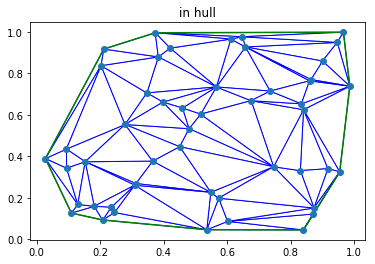

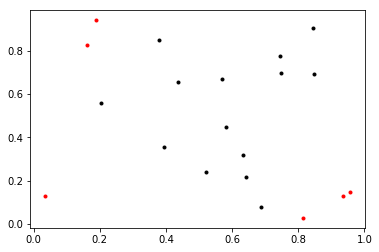

In [4]:
tested = np.random.rand(20,2)
cloud  = np.random.rand(50,2)

plot_in_hull(tested, cloud)

In [30]:
x = p
y = phi_list
points = []
for i in range(len(x)):
    points.append((x[i], y[i]))
    
l, u = convex_hull(points)

pointss = np.transpose(np.vstack((x, y)))
hull = ConvexHull(pointss)

# plt.plot(pointss[:,0], pointss[:,1], 'bo')


In [26]:
print(l)

[(0.021547799949644206, -0.27961142218678514), (0.022290170234720217, -0.27976800501347077), (0.033594203231599264, -0.2802371574179372), (0.06170791535808475, -0.27227515581124195), (0.9232420337296532, 0.04105661106945835)]


In [27]:
print(u)

[(0.9928057796605946, 0.08544162715078146), (0.6321285233210271, 0.005973386089659141), (0.6240359968635721, 0.004188222343996276), (0.612001027587727, 0.0014039299097994944), (0.6075863047711573, 0.0003435010532503238), (0.5939388725556648, -0.0030683116863597804), (0.5918665376604781, -0.0036041319018166977), (0.5903675640570665, -0.003994630646749403), (0.575846048445015, -0.007905221885563612), (0.5659255165223582, -0.01071032334730306), (0.562345576404365, -0.011749301802581932), (0.5463818521413961, -0.01655544979484602), (0.543809340300429, -0.01735646663248936), (0.5424742848492697, -0.017775076373488567), (0.53745079467777, -0.019368010857886538), (0.5158393570145448, -0.02654239607480824), (0.5103462240198391, -0.028449233532793355), (0.5066708021808997, -0.029743951888719283), (0.50352406028377, -0.030864455729893922), (0.49277720686652554, -0.03477484907060081), (0.49092067734488765, -0.03546347568877087), (0.4830418405914178, -0.03842884495478535), (0.4759203130337656, -0.

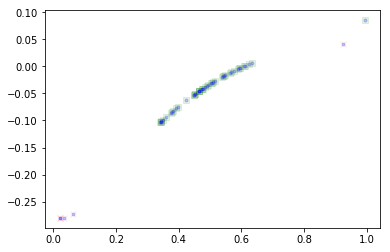

In [33]:
#plt.plot(x, y, 'ko', alpha=0.1)
plt.plot([l[i][0] for i in range(len(l))], [l[i][1] for i in range(len(l))], 'rx', alpha=0.1)
plt.plot([u[i][0] for i in range(len(u))], [u[i][1] for i in range(len(u))], 'gs', alpha=0.1)
for v in hull.simplices:
    plt.plot(pointss[v, 0], pointss[v, 1], 'b.', alpha=0.1)

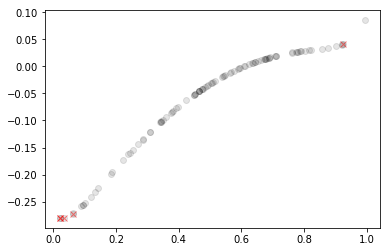

In [35]:
plt.plot(x, y, 'ko', alpha=0.1)
plt.plot([l[i][0] for i in range(len(l))], [l[i][1] for i in range(len(l))], 'rx', alpha=0.5)
# plt.plot([u[i][0] for i in range(len(u))], [u[i][1] for i in range(len(u))], 'gs', alpha=0.1)
# for v in hull.simplices:
#     plt.plot(pointss[v, 0], pointss[v, 1], 'b.', alpha=0.1)


[[-0.3927652  -0.9148722   0.09351122 -2.40253187]
 [-0.38720435 -0.79019944 -0.47503435 -2.30789378]
 [-0.59299746 -0.73814951 -0.32169756 -2.35219127]
 [ 0.51642803 -0.81361411 -0.26708458 -2.863858  ]
 [-0.11691754 -0.98111477 -0.15409117 -2.34922871]
 [ 0.32887524  0.54338169  0.77238424 -2.68525431]
 [ 0.84259815  0.41182222 -0.34703144 -2.67407613]
 [ 0.08328508  0.71104777 -0.69819386 -2.87815347]
 [ 0.66620399  0.72830633  0.16044358 -2.63608523]
 [ 0.91952995 -0.13812551 -0.36794839 -2.59292761]
 [ 0.90075261 -0.03325471 -0.43305757 -2.6017572 ]
 [ 0.9935987  -0.08613079 -0.07309656 -2.59686422]
 [ 0.91270567  0.18659198 -0.36352689 -2.6169141 ]
 [-0.20200266 -0.63217043  0.7480344  -2.56113938]
 [-0.16690391 -0.61778646  0.7684289  -2.56093609]
 [ 0.21805399 -0.58515248  0.78105636 -2.61722086]
 [ 0.24093363 -0.51180711  0.82462383 -2.58766692]
 [ 0.110931    0.08948733  0.98979105 -2.6854949 ]
 [-0.44050492  0.3378369   0.83175817 -2.74174935]
 [-0.49069124 -0.45390383 -0.74

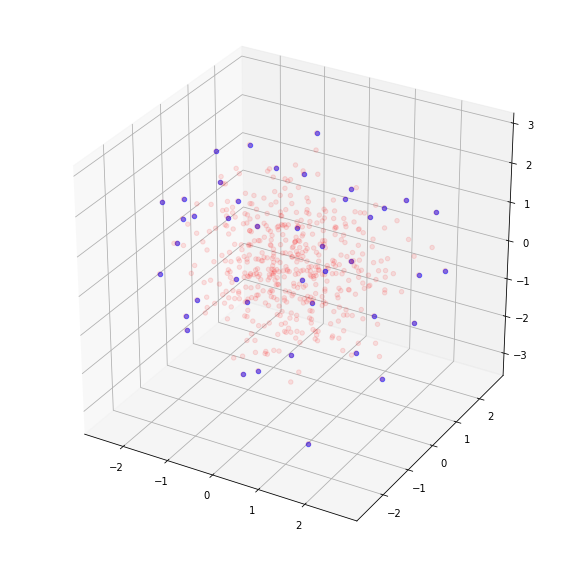

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
data = np.random.normal(0, 1, (500, 3))
hull = ConvexHull(data)

x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

ax.scatter(xs=x, ys=y, zs=z, c='r', alpha=0.1)
for v in hull.vertices:
    ax.scatter(xs=data[v, 0], ys=data[v, 1], zs=data[v, 2], c='b', alpha=0.5)
print(hull.equations)

In [26]:
print(hull.vertices)

[  3  27  46  59  87 105 109 135 139 143 168 178 181 183 184 190 202 211
 224 227 229 233 242 266 280 301 334 341 343 351 363 389 403 446 456 460
 474]


## Our Results

## M-ary Channels

In [23]:
''' Helper Functions '''
def stochastic_matrix(n, m):
    matrix = np.random.rand(n,m)
    return matrix/matrix.sum(axis=0)

def f_divergence(f, p, q):
    result = 0
    for i in range(len(p)):
        result = result + q[i]*f(p[i]/q[i])
    return result

def phi(f, g, lambda_, p_xw, p_x, p_yw, p_y):
    result = f_divergence(f, p_xw, p_x)[0] - lambda_*f_divergence(g, p_yw, p_y)[0]
    return result

def BSC_matrix(delta):
    return np.matrix([[1-delta, delta], [delta, 1-delta]])
#def Mary_matrix()
#def noisy_typewriter()
def random_channel(n, m):
    return stochastic_matrix(n, m)

In [29]:
T = BSC_matrix(0.1)
p_x = stochastic_matrix(m, 1)
p_y = stochastic_matrix(n, 1)

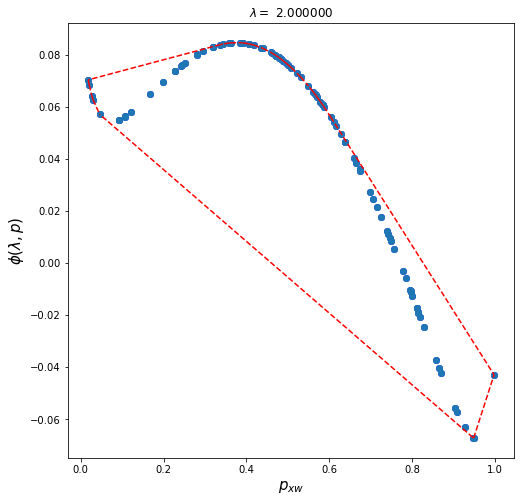

In [13]:
''' Create the Channel Transition Matrix '''
n = 2
m = 2
#T = BSC_matrix(0.1)
#p_x = stochastic_matrix(m, 1)
#p_y = stochastic_matrix(n, 1)

f_kl = lambda t: t*np.log(t)
g_kl = lambda t: t*np.log(t)

f_ci = lambda t: t**2 - 1
g_ci = lambda t: t**2 - 1

lambda_ = 2

mc_size = 100
phi_list = []
p = []
for i in range(mc_size):
    #print(i)
    p_xw = stochastic_matrix(n, 1)
    p_yw = np.dot(T, p_xw)
    
    phi_list.append(float(phi(f_kl, g_kl, lambda_, p_xw, p_x, p_yw, p_y)))
    p.append(float(p_xw[0]))
    #print(p_xw)
    #print('=================')
    #print(phi(f_kl, g_kl, lambda_, p_xw, p_x, p_yw, p_y))

plt.figure(figsize=(8, 8))
plt.plot(p, phi_list, 'bo')
#plt.xlabel('$D_f(P_{X|W}\|P_X)$', fontsize = 15)
#plt.ylabel('$D_g(P_{Y|W}\|P_Y)$', fontsize = 15)
plt.xlabel('$p_{xw}$', fontsize = 15)
plt.ylabel('$\phi(\lambda, p)$', fontsize = 15)
plt.title('$\lambda = $ %f' %lambda_)

points = np.transpose(np.vstack((p, phi_list)))
hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r--')


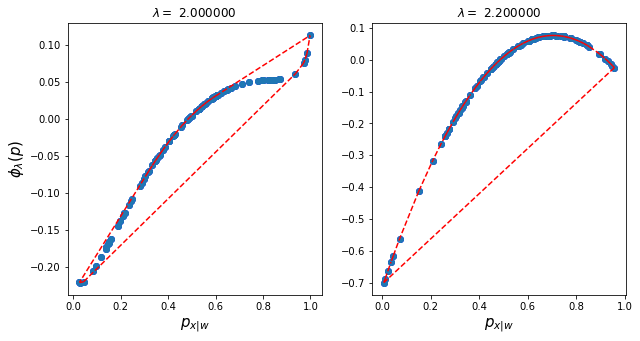

In [37]:
''' Create the Channel Transition Matrix '''
T = BSC_matrix(0.1)
p_x = stochastic_matrix(m, 1)
p_y = stochastic_matrix(n, 1)
n = 2
m = 2
#T = BSC_matrix(0.1)
#p_x = stochastic_matrix(m, 1)
#p_y = stochastic_matrix(n, 1)

f_kl = lambda t: t*np.log(t)
g_kl = lambda t: t*np.log(t)

f_ci = lambda t: t**2 - 1
g_ci = lambda t: t**2 - 1

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

lambda_ = 2

mc_size = 100
phi_list = []
p = []
for i in range(mc_size):
    #print(i)
    p_xw = stochastic_matrix(n, 1)
    p_yw = np.dot(T, p_xw)
    
    phi_list.append(float(phi(f_kl, g_kl, lambda_, p_xw, p_x, p_yw, p_y)))
    p.append(float(p_xw[0]))
    #print(p_xw)
    #print('=================')
    #print(phi(f_kl, g_kl, lambda_, p_xw, p_x, p_yw, p_y))

#plt.figure(figsize=(8, 8))
ax[0].plot(p, phi_list, 'bo')
#plt.xlabel('$D_f(P_{X|W}\|P_X)$', fontsize = 15)
#plt.ylabel('$D_g(P_{Y|W}\|P_Y)$', fontsize = 15)
ax[0].set_xlabel('$p_{x|w}$', fontsize = 15)
ax[0].set_ylabel('$\phi_\lambda(p)$', fontsize = 15)
ax[0].set_title('$\lambda = $ %f' %lambda_)

points = np.transpose(np.vstack((p, phi_list)))
hull = ConvexHull(points)

ax[0].plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    ax[0].plot(points[simplex, 0], points[simplex, 1], 'r--')
'''=================================================================='''
lambda_ = 2.2

mc_size = 100
phi_list = []
p = []
for i in range(mc_size):
    #print(i)
    p_xw = stochastic_matrix(n, 1)
    p_yw = np.dot(T, p_xw)
    
    phi_list.append(float(phi(f_ci, g_ci, lambda_, p_xw, p_x, p_yw, p_y)))
    p.append(float(p_xw[0]))
    #print(p_xw)
    #print('=================')
    #print(phi(f_kl, g_kl, lambda_, p_xw, p_x, p_yw, p_y))

#plt.figure(figsize=(8, 8))
ax[1].plot(p, phi_list, 'bo')
#plt.xlabel('$D_f(P_{X|W}\|P_X)$', fontsize = 15)
#plt.ylabel('$D_g(P_{Y|W}\|P_Y)$', fontsize = 15)
ax[1].set_xlabel('$p_{x|w}$', fontsize = 15)
#ax[1].set_ylabel('$\phi(\lambda, p)$', fontsize = 15)
ax[1].set_title('$\lambda = $ %f' %lambda_)

points = np.transpose(np.vstack((p, phi_list)))
hull = ConvexHull(points)

ax[1].plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    ax[1].plot(points[simplex, 0], points[simplex, 1], 'r--')

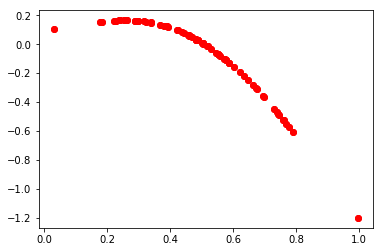

In [19]:
plt.plot(points[hull.simplices, 0], points[hull.simplices, 1], 'ro')

# TEST

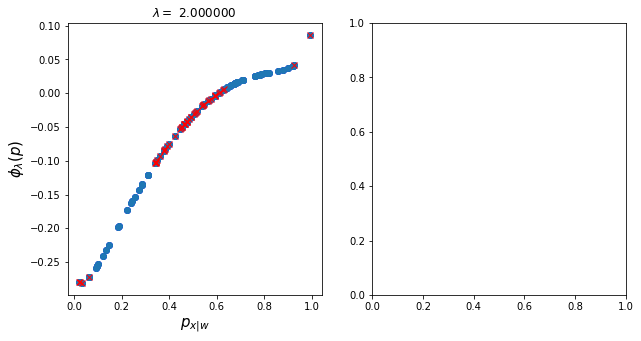

In [24]:
''' Create the Channel Transition Matrix '''
n = 2
m = 2
T = BSC_matrix(0.1)
p_x = stochastic_matrix(m, 1)
p_y = stochastic_matrix(n, 1)

#T = BSC_matrix(0.1)
#p_x = stochastic_matrix(m, 1)
#p_y = stochastic_matrix(n, 1)

f_kl = lambda t: t*np.log(t)
g_kl = lambda t: t*np.log(t)

f_ci = lambda t: t**2 - 1
g_ci = lambda t: t**2 - 1

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

lambda_ = 2

mc_size = 100
phi_list = []
p = []
for i in range(mc_size):
    #print(i)
    p_xw = stochastic_matrix(n, 1)
    p_yw = np.dot(T, p_xw)
    
    phi_list.append(float(phi(f_kl, g_kl, lambda_, p_xw, p_x, p_yw, p_y)))
    p.append(float(p_xw[0]))
    #print(p_xw)
    #print('=================')
    #print(phi(f_kl, g_kl, lambda_, p_xw, p_x, p_yw, p_y))

#plt.figure(figsize=(8, 8))
ax[0].plot(p, phi_list, 'bo')
#plt.xlabel('$D_f(P_{X|W}\|P_X)$', fontsize = 15)
#plt.ylabel('$D_g(P_{Y|W}\|P_Y)$', fontsize = 15)
ax[0].set_xlabel('$p_{x|w}$', fontsize = 15)
ax[0].set_ylabel('$\phi_\lambda(p)$', fontsize = 15)
ax[0].set_title('$\lambda = $ %f' %lambda_)

points = np.transpose(np.vstack((p, phi_list)))
hull = ConvexHull(points)

ax[0].plot(points[:,0], points[:,1], 'o')
for v in hull.vertices:
    ax[0].plot(points[v, 0], points[v, 1], 'rx')

In [82]:
print(simps(phi_list, p))

0.108718925688


In [83]:
print(simps(points[hull.vertices, 1][np.argsort(points[hull.vertices, 0])], np.sort(points[hull.vertices, 0])))

-0.583006877588


-0.0755447991761


In [36]:
print(hull.vertices)

[26 77  3 79 78 90 73 87  7  8 74 85 15 86 62 11 34 81 30 98 17 28 55 72 29
 84 69 27 32 68 66 57 82 16 80  1 21 33 92 93 25 76 35 70 61 47 56 49 23 40
 43]


In [6]:
''' Create the Channel Transition Matrix '''
n = 3
m = 3
T = random_channel(n, m)
p_x = stochastic_matrix(m, 1)
p_y = stochastic_matrix(n, 1)

f_kl = lambda t: t*np.log(t)
g_kl = lambda t: t*np.log(t)

f_ci = lambda t: t**2 - 1
g_ci = lambda t: t**2 - 1

lambda_ = 1.9

mc_size = 100
phi_list = []
p = []
for i in range(mc_size):
    #print(i)
    p_xw = stochastic_matrix(n, 1)
    p_yw = np.dot(T, p_xw)
    
    phi_list.append(float(phi(f_kl, g_kl, lambda_, p_xw, p_x, p_yw, p_y)))
    p.append(float(p_xw[0]))
    #print(p_xw)
    #print('=================')
    #print(phi(f_kl, g_kl, lambda_, p_xw, p_x, p_yw, p_y))

points = np.transpose(np.vstack((p, phi_list)))
hull = ConvexHull(points)
for simplex in hull.simplices:
    Axes3D.plot(points[simplex, 0], points[simplex, 1],)(points[simplex, 0], points[simplex, 1])
    
'''
plt.figure(figsize=(8, 8))
plt.plot(p, phi_list, 'bo')
#plt.xlabel('$D_f(P_{X|W}\|P_X)$', fontsize = 15)
#plt.ylabel('$D_g(P_{Y|W}\|P_Y)$', fontsize = 15)
plt.xlabel('$p_{xw}$', fontsize = 15)
plt.ylabel('$\phi(\lambda, p)$', fontsize = 15)
plt.title('$\lambda = $ %f' %lambda_)

points = np.transpose(np.vstack((p, phi_list)))
hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r--')
'''


[ 0.21305437  0.0024872 ] [ 0.29027032 -0.07146007]
[ 0.00919632  0.0024872 ] [-0.90275015 -0.07146007]
[ 0.76726723  0.89156827] [ 0.7487858   1.29624851]
[ 0.88694623  0.89156827] [ 1.3243453   1.29624851]
[ 0.88694623  0.21305437] [ 1.3243453   0.29027032]
[ 0.02299636  0.07445019] [-0.94279109 -0.95320603]
[ 0.02299636  0.00919632] [-0.94279109 -0.90275015]
[ 0.64698993  0.55906021] [ 0.33224367  0.0330707 ]
[ 0.64698993  0.76726723] [ 0.33224367  0.7487858 ]
[ 0.41278798  0.55906021] [-0.36546188  0.0330707 ]
[ 0.09921287  0.07445019] [-0.93288964 -0.95320603]
[ 0.20740224  0.3197222 ] [-0.79865053 -0.58589465]
[ 0.20740224  0.15957538] [-0.79865053 -0.87056917]
[ 0.38075205  0.3197222 ] [-0.44569809 -0.58589465]
[ 0.38075205  0.41278798] [-0.44569809 -0.36546188]
[ 0.15108383  0.15957538] [-0.88079105 -0.87056917]
[ 0.15108383  0.09921287] [-0.88079105 -0.93288964]


"\nplt.figure(figsize=(8, 8))\nplt.plot(p, phi_list, 'bo')\n#plt.xlabel('$D_f(P_{X|W}\\|P_X)$', fontsize = 15)\n#plt.ylabel('$D_g(P_{Y|W}\\|P_Y)$', fontsize = 15)\nplt.xlabel('$p_{xw}$', fontsize = 15)\nplt.ylabel('$\\phi(\\lambda, p)$', fontsize = 15)\nplt.title('$\\lambda = $ %f' %lambda_)\n\npoints = np.transpose(np.vstack((p, phi_list)))\nhull = ConvexHull(points)\n\nplt.plot(points[:,0], points[:,1], 'o')\nfor simplex in hull.simplices:\n    plt.plot(points[simplex, 0], points[simplex, 1], 'r--')\n"

In [9]:
print(p)

[0.31807434895039083, 0.3123862289404462, 0.4675881435983251, 0.8869462325893231, 0.3852005395958092, 0.16824175665583635, 0.12124714570273117, 0.023979192206247505, 0.4124976895654027, 0.20740223923993717, 0.11939188486900397, 0.5767806429836925, 0.30579025521707276, 0.2595962055327212, 0.7159492102376591, 0.8183437690270527, 0.12721656107603233, 0.2933183382555512, 0.4770374901746017, 0.09921286520610546, 0.7672672288186139, 0.05043687641419786, 0.00919632284806228, 0.20319863775251218, 0.1411515151612267, 0.09750602865967099, 0.33863668683479164, 0.46324984457833557, 0.2602210858768904, 0.1601587701457768, 0.42524169820785374, 0.6536105536256122, 0.2748704433444216, 0.8540450095218056, 0.3210439814354799, 0.4127879757071798, 0.038672536226845695, 0.4761995344662317, 0.21010293904367303, 0.11386392155008249, 0.03161423027596902, 0.46164823440368735, 0.02299636346214815, 0.07445018506363182, 0.26011804572012337, 0.15957538267101892, 0.6297676953647515, 0.5422095209997951, 0.3643057004

In [77]:
#np.random.seed(100)

''' Create the Channel Transition Matrix '''
n = 1
m = 1
p_xw = stochastic_matrix(m, 1)
T = stochastic_matrix(n,m)
p_yw = np.dot(T, p_xw)

p_x = stochastic_matrix(m, 1)
p_y = stochastic_matrix(n, 1)

f_kl = lambda t: t*np.log(t)
g_kl = lambda t: t*np.log(t)

lambda_ = 1

mc_size = 1000
phi_list = []
for i in range(mc_size):
    p_xw = stochastic_matrix(m, 1)
    phi_list.append(phi(f_kl, g_kl, lambda_, p_xw, p_x, p_yw, p_y))
    
    
    
    
print(phi(f_kl, g_kl, lambda_, p_xw, p_x, p_yw, p_y))

0.0


In [13]:
p = stochastic_matrix(1, 1)
q = stochastic_matrix(1, 1)

print(p)
print(q)
f_kl = lambda t: t*np.log(t)
print(f_divergence(f_kl, p, q))

[[ 0.23624848]
 [ 0.08746248]
 [ 0.27917688]
 [ 0.12509262]
 [ 0.27201954]]
[[ 0.16314046]
 [ 0.20348313]
 [ 0.27197534]
 [ 0.09624802]
 [ 0.26515304]]
[ 0.06066609]


In [9]:
matrix = np.random.rand(10, 5)
print(matrix/matrix.sum(axis=0))

[[ 0.1711128   0.18585547  0.12667749  0.1722065   0.11964093]
 [ 0.16320908  0.02968973  0.00414926  0.0117671   0.19950734]
 [ 0.0522137   0.08514792  0.19201998  0.07739423  0.09406118]
 [ 0.04924662  0.07206406  0.11505224  0.12455079  0.01398236]
 [ 0.0617001   0.15907198  0.18704552  0.07720522  0.02069227]
 [ 0.06568359  0.03971204  0.06562562  0.06092879  0.00246806]
 [ 0.18863181  0.10474842  0.1360541   0.12288775  0.06917972]
 [ 0.05898885  0.07974434  0.0151514   0.1707401   0.18483561]
 [ 0.18790163  0.18787022  0.00403243  0.00652935  0.1938976 ]
 [ 0.00131183  0.05609584  0.15419195  0.17579016  0.10173494]]


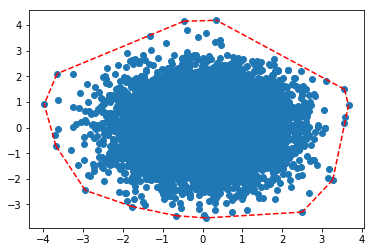

In [25]:
points = np.random.normal(0, 1, size=(10000, 2))
hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r--')

In [67]:
print(phi_list[0].shape)

(1, 1)


In [13]:
print(f_divergence(f_kl, p_x, p_y)[0])

1.45951943083


In [47]:
print(points.shape)

(2, 100)


In [27]:
print(np.vstack(([1, 2, 3], [4, 5, 6])))

[[1 2 3]
 [4 5 6]]


In [41]:
print(p)

[0.4608590366158236, 0.5391054314763023, 0.43182183848362465, 0.03373430503139351, 0.5490202361413793, 0.6190441468300831, 0.5340737235316476, 0.7417998372589094, 0.8337456818946629, 0.8033765818951015, 0.9255398656079338, 0.21017247885536586, 0.4261012425668463, 0.8798529873379611, 0.9754330649673518, 0.6624662201179605, 0.34187707686284047, 0.661218311551545, 0.2884610481312894, 0.5007421677273733, 0.9355677023244409, 0.8903517008864863, 0.14598185252524032, 0.3939972283867443, 0.24658670687082082, 0.20217378429346994, 0.4934440995730508, 0.8293241215791847, 0.9839793581954034, 0.09786366190252656, 0.27790145908299657, 0.6063233163844179, 0.4901622518225669, 0.7232243014550495, 0.2337673656785284, 0.6269351265103026, 0.45205396129939546, 0.4306404160571256, 0.8736244640416067, 0.9694283045154444, 0.5986062057188899, 0.359026702109784, 0.663452738463199, 0.5897740759609467, 0.2630002507571572, 0.04091718553203557, 0.020077762777591417, 0.5695091727429363, 0.2942708653233008, 0.0606193

In [43]:
np.matrix([1, 2, 3], [4, 5, 6])

TypeError: data type not understood